In [401]:
#imports
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from numpy import unravel_index
from moviepy.editor import VideoFileClip
from IPython.display import HTML
%matplotlib inline

In [2]:
#%run Line.py

#### Constants & globals

In [3]:
#local location folders of our calibration and test images
cal_loc = "camera_cal/"
test_img_loc = "test_images/"




#### Data Structure Classes

In [402]:
#A class so we can keep track of information across frames and average frames across a 3-frame span when drawing lines
class Line():
    def __init__(self):
        self.detected = False  
        self.allY = None
        self.allX = None
        self.fit= None
        self.prevFits = []
        self.resetIn = 5
        self.curve = 0

### Calibrate Camera

In [404]:
#With our calibration images, we feed those imahes into cv2's findChessboardCorners
#method to obtain corners in the current calibration image, we add these corners to a list of corners
#that each have their respective object points. Returns the undistort matrix M
def Get_Undistort_M():
    objp = np.zeros((6*9,3), np.float32)
    objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2)
    objpoints = [] 
    imgpoints = [] 
    images = glob.glob(cal_loc+'*.jpg')
    isize = None
    for idx, fname in enumerate(images):
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        if isize == None:
            isize = img.shape
        ret, corners = cv2.findChessboardCorners(gray, (9,6), None)
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)
            cv2.drawChessboardCorners(img, (9,6), corners, ret)
    return cv2.calibrateCamera(objpoints,imgpoints, (isize[1], isize[0]),None,None)


In [405]:
#get matrix, calibration points
cal_points = Get_Undistort_M();

In [408]:
#function so we can reuse, undistort images at runtime
def Undistort_Image(img):
    return cv2.undistort(img, cal_points[1], cal_points[2], None, cal_points[1])

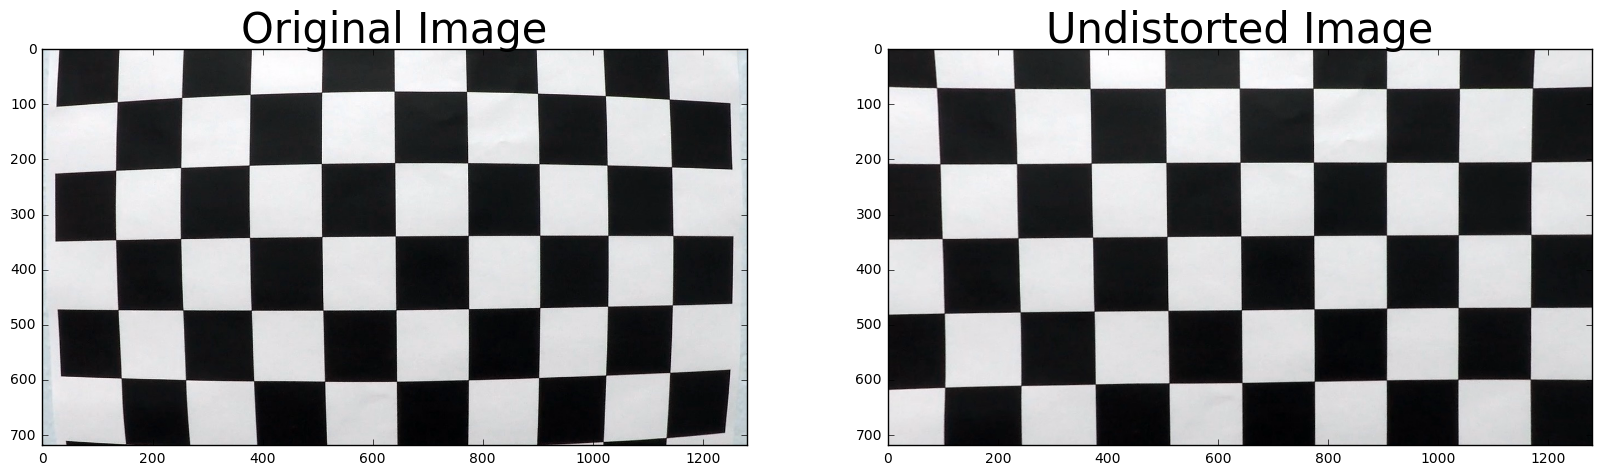

In [409]:
#here is a test image for undistortion. The undistorted image has a much flatter view than the original distorted image.
img = cv2.imread(cal_loc+"calibration1.jpg")
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(Undistort_Image(img))
ax2.set_title('Undistorted Image', fontsize=30)

#### Select Color Space

In [9]:
#For testing, view the impact of the HLS color space.
def hls_select(img, thresh=(0, 255)):
    hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
    s_channel = hls[:,:,2]
    binary_output = np.zeros_like(s_channel)
    binary_output[(s_channel > thresh[0]) & (s_channel <= thresh[1])] = 1
    return binary_output

#### Threshold Functions

In [377]:
#All the gradients we learned in the lessons. I have added some code to visualize the image per threshold function 
#after a binary image is obtained. 
def abs_sobel_thresh(img, orient='x', thresh_min=100, thresh_max=150,show_output = False):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    if orient == 'x':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
    else:
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1)
    abs_sobel = np.absolute(sobel)
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
    if show_output:
        plt.imshow(sxbinary, cmap="gray")
        plt.show()
    return sxbinary
def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255),show_output = False):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1
    if show_output:
        plt.imshow(binary_output, cmap="gray")
        plt.show()
    return binary_output
def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2),show_output = False):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1
    if show_output:
        plt.imshow(binary_output, cmap="gray")
        plt.show()
    return binary_output

#### Utility Functions

In [11]:
# This function is to mask out areas that we are not concerned with. This helps get rid of outliers and makes finding
# lines to a more local space per side of the image
def region_of_interest(img,region_vertices):
    mask = np.zeros_like(img)   
    if len(img.shape) > 2:
        channel_count = img.shape[2]
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255  
    cv2.fillPoly(mask, region_vertices, ignore_mask_color)
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

In [410]:
#here I spent a while experimenting with the thresholds. 
#I experimented with the sobel, gradient magnitude and gradient direction.
# What I I found to work the best is to use the color space thresholds on the LAB and LUV color spaces. 
# The L channel in the LUV color spaces gives us a look at the luminence of the color which we can use to indicate
# the lighter color road lanes. 
# The B channel in the LAB color space is a spectrum along the blue and yellow color. Since road lines are yellow a
# great deal, we can use this to determine lane lines as well. 

#Ive added output plots when show_output = True

def compute_thresholds(show_output,img, s_thresh=(170, 255), sx_thresh=(20, 100)):
    s_binary = hls_select(img,color_space_thresh_minmax)

    #sobel = abs_sobel_thresh(image, orient='x', thresh_min=20, thresh_max=100,show_output = show_output)
    #dir_ = dir_threshold(image, sobel_kernel=15, thresh=(0.7, 1.3),show_output = show_output)
    mag = mag_thresh(image, sobel_kernel=3, mag_thresh=(30, 100),show_output = show_output)
    
   
    bc = cv2.cvtColor(img, cv2.COLOR_RGB2Lab)[:,:,2]
    lc = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)[:,:,0]  
    
    if show_output:
        plt.imshow(bc)
        plt.show()
    if show_output:
        plt.imshow(lc)
        plt.show()
        
    bmin = 145
    bmax = 215
    b = np.zeros_like(bc)
    b[(bc >= bmin) & (bc <= bmax)] = 1
    

    lmin = 215
    lmax = 255
    l = np.zeros_like(lc)
    l[(lc >= lmin) & (lc <= lmax)] = 1

    combined = np.zeros_like(b)
    
    combined[(b == 1) | (l== 1)] = 1
    if show_output:
        plt.imshow(combined, cmap="gray")
        plt.show()
    return combined

#### Transform functions

In [411]:
#This function will warp our images to we can get a better perspective on the image. We would like to work with our
# images without the horizon effect to determine slopes and lines. using warpPerspective, we can get a top-down
# image to easier find lanes and apply calculations
def birdseye(img):
    src = np.float32([[595,450],[705,450],[1125,720],[200,720]])
    dst = np.float32([[325,0],[1100,0],[950,720],[325,720]])
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    warped = cv2.warpPerspective(img, M,(1280,720), flags=cv2.INTER_LINEAR)
    return warped, M, Minv

In [253]:
#Create instances of our line class
left_line = Line()
right_line = Line()

#### Lane Extraction and Impose

In [222]:
##validate found lines, once we got a set of lines, lets check they are somewhat meaningful to what were looking for.
# We look for the spacing of the right and left lines and the curvature of the the lines to see if they make sense in 
# order to be road lane lines
def validateLines(left_fix, right_fit,left_curve,right_curve):
    return True
    #check spacing
    min_spacing_threshold = 400
    max_spacing_threshold = 1000
    
    max_curve_diff_threshold = 2000
    
    for i in range(0,10):
        l = np.poly1d(left_fix)(i * 72)
        r = np.poly1d(right_fit)(720)
        spacing = r - l
        if spacing > max_spacing_threshold:
            #print("fail spacing " + str(spacing))
            return False
        if spacing < min_spacing_threshold:
            #print("fail spacing " + str(spacing))
            return False
        
    if abs(left_curve - right_curve) > max_curve_diff_threshold:
        #print("fail curve " + str(abs(left_curve - right_curve)))
        return False
    
    return True
        

In [277]:
# here we:
#     From the bottom of the warped binary image and working upward at a 50px interval, we determine the left and right
# peaks. We split the image into two sides horzontally and then from those two images we obtain a window towards
# the center of these two sides with a 100px horizontal window on each side. We then take the vertical sum of all 
# columns in this window and grab the column with the highest sum (essentially taking the histogram of the window). 
# We then take these two sum maxes as our left and right peaks. Once we find out first peaks for thr bottom of the
# image, we can use these peaks as the starting point of repeating this process on our next block up the image. 
# After the entire image has been vertically traversed in this fashion, we will have a set of x,y coordinates for 
# both left and right lines.
# With these coordinates we can obtain a polynomial using np.ployfit which will return us the polynomial 
# coefficients. We assign the x and y values of the current frame that we've found, along with the current polynomial
# that we've obtained from polyfit and we store them in our left_line and right_line global objects 

# If we already traversed the previous frame for the lines, searching the entire image for histogram peaks, then we 
# can use the previous polynomial that we have obtained to take a better guess at which where the current line points
# will be. If this fails, if it happens that we cant find resonable lines based off the previous found polynomial, 
# then we can start the search process over again that we started with in the beginning
def getNewFitCoefficientsAndPoints(original,res,show_output,noreset):
    reset = not noreset
    #reset = True
    #print(reset)
    if show_output:
        chunksize = 5
        for i in range(chunksize):
            histogram = np.sum(res[(i * (res.shape[0]/chunksize)):((i+1) * (res.shape[0]/chunksize)),:], axis=0)
            plt.figure(figsize=(10,.5))
            plt.plot(histogram)
            plt.show()
    if not reset:
        offset = 100
        last_l = np.poly1d(left_line.fit)(720)
        if last_l < 200 or last_l > 1100:
            reset = True
            
        last_r = np.poly1d(right_line.fit)(720)
        if last_r < 200 or last_r > 1100:
            reset = True
            
        if not reset:
            leftpeak = int(np.argmax(np.sum(res[res.shape[0]-100:,last_l-offset:last_l+offset], axis=0)))
            rightpeak = int(np.argmax(np.sum(res[res.shape[0]-100:,last_r-offset:last_r+offset], axis=0)))
        
    if reset:
        offset = 100
        leftpeak = int(np.argmax(np.sum(res[res.shape[0]/2:,0:res.shape[1]/2], axis=0)))
        rightpeak = int(np.argmax(np.sum(res[res.shape[0]/2:,res.shape[1]/2:res.shape[1]], axis=0)) + res.shape[1]/2)
   
    
    leftline = np.zeros(shape=(0,2))
    rightline = np.zeros(shape=(0,2))

    stepsizey = 50
    stepsizex = int(res.shape[1]/12) #our increment box width is roughly 1/12th of the image width
    
    for i in range(int(res.shape[0]/10)):
        q = 720 - int((i * 10))
        d = 100
        if(q < 100):
            d = q
        if not reset:
            leftpeak = np.poly1d(left_line.fit)(q)
            rightpeak = np.poly1d(right_line.fit)(q)
            pass # assign left peak and right peak to the calculation of latest fit of r an l lines
        
        left = res[q-d:q,leftpeak - offset:leftpeak+offset]
        right = res[q-d:q,rightpeak - offset:rightpeak+offset]
        
        if np.sum(left) != 0:
            leftpeak = int(np.argmax(np.sum(left,axis=0)) + (leftpeak - offset))     
            leftline = np.vstack((leftline,[leftpeak,q]))
        
        if np.sum(right) != 0:
            rightpeak = int(np.argmax(np.sum(right,axis=0)) + (rightpeak - offset))
            rightline = np.vstack((rightline,[rightpeak,q]))

    lx = leftline[:,0]
    ly = leftline[:,1]
    rx = rightline[:,0]
    ry = rightline[:,1]
    
    if show_output:
        plt.ylim([0,720])
        plt.gca().invert_yaxis()
        plt.xlim([0,1280])
    
    #if np.sum(lx) == 0:
    #    return original
    
    if len(lx) == 0 or len(ly) == 0 or len(rx) == 0 or len(ry) == 0:
        #print("none")
        left_line.detected  = False
        right_line.detected = False
        return
    
    left_fit = np.polyfit(ly, lx, 2)
    right_fit = np.polyfit(ry, rx, 2)
    
    #Now to calculate curvatures
    
    ### Here we can take the formulas given to us in the lecture and apply then fo the points we have obtained 
    ### and the definition of how many meters, approximately , are per image pixel. We can then use these
    ### to find the curvature in meters. We will display these on the image at the end of the pipline
    ym_per_pix = 30./720 #  per pixel in y dir
    xm_per_pix = 3.7/700 #  per pixel in x dir
    left_fit_cr = np.polyfit(ly*ym_per_pix, lx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ry*ym_per_pix, rx*xm_per_pix, 2)
    left_curverad = ((1 + (2*left_fit_cr[0]*np.max(ly) + left_fit_cr[1])**2)**1.5) \
                                 /np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*np.max(ry) + right_fit_cr[1])**2)**1.5) \
                                    /np.absolute(2*right_fit_cr[0])
    
    
    lines_valid = validateLines(left_fit,right_fit,left_curverad,right_curverad)
    #print(lines_valid)
    if lines_valid:
        #if the lines that we have found are valid, then we store them in our global line objects so they can be used
        #for the next pass. We also store the polynomials in a history list because when we draw the lines onto the 
        #image, we will take the average of the last 3 lines that we have found to give a smoother transitions of lines
        # and should help to eliminate some jitters
        left_line.detected = True
        right_line.detected = True
        left_line.allX = lx
        left_line.allY = ly
        right_line.allX = rx
        right_line.allY = ry
        
        left_line.fit = left_fit
        left_line.prevFits.append(left_fit)
        right_line.fit = right_fit
        right_line.prevFits.append(right_fit)
        
        if len(left_line.prevFits) > 3:
            left_line.prevFits.pop(0)
        if len(right_line.prevFits) > 3:
            right_line.prevFits.pop(0)
            
        right_line.curve = right_curverad
        left_line.curve = left_curverad
            
    else:
        left_line.detected  = False
        right_line.detected = False
        
    
    
    #print (right_line.prevFits)
    return left_fit, right_fit
    

In [399]:
# this is the beginning of the search and placement of lines. 
# first we call our line searching method above. After we have found a line we then take the average of the last
# 3 lines to obtain polynomial coeffcients to draw. We calculate the left line and right lines to draw by calculating
# the polynomial against a vector of all points in the y dimension. We then create a a matrix the size of the warped
# (birdseye) image and draw the area inside of the averaged lines using np.fillypoly. We then unwarp this new image
# with the inverse matrix we stored earlier from the process of warping into birdseye view. We then impose this image 
# into the original image using cv2 addWeighted. We return this annotated image. 
def extractLanesAndImpose(original,bird,show_output,Minv,bird2):
    res = bird
    #left_fit, right_fit = 
    getNewFitCoefficientsAndPoints(original,res,show_output,left_line.detected & right_line.detected)

    
    left_fit = np.average(np.array(left_line.prevFits),0)
    right_fit = np.average(np.array(right_line.prevFits),0)
    
    yrange = np.arange(0,720)
    
    left_fitx = left_fit[0]*yrange **2 + left_fit[1]*yrange  + left_fit[2]
    right_fitx = right_fit[0]*yrange **2 + right_fit[1]*yrange  + right_fit[2]
    
    
    
    if show_output:
        plt.plot(left_fitx, yrange, color='green', linewidth=3)
        plt.plot(right_fitx, yrange, color='green', linewidth=3)
        plt.imshow(bird)

    warp_zero = np.zeros_like(res).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    pts_left = np.array([np.transpose(np.vstack([left_fitx, yrange ]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, yrange ])))])
    
    
    
    pts = np.hstack((pts_left, pts_right))

    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    newwarp = cv2.warpPerspective(color_warp, Minv, (original.shape[1], original.shape[0])) 
    result = cv2.addWeighted(original, 1, newwarp, 0.3, 0)
    
    
    rightx_int = right_fit[0]*720**2 + right_fit[1]*720 + right_fit[2]
    leftx_int = left_fit[0]*720**2 + left_fit[1]*720 + left_fit[2]
  
    position = (rightx_int+leftx_int)/2
    distance_from_center = round(abs((640 - position)*3.7/700) ,3)
    dir = "right"
    if position > 640:
        dir = "left"
    cv2.putText(result, str(distance_from_center) +' '+ dir +' meters from center', (100,80),
                 fontFace = 16, fontScale = 1, color=(255,255,255), thickness = 2)
       
    cv2.putText(result, str(round(int((left_line.curve+right_line.curve)/2),4))+' meters radius', (120,140),
             fontFace = 16, fontScale = 1, color=(255,255,255), thickness = 2)
    
    return result

    

#### Pipeline Definitions

In [412]:
# This is the pipeline of operations. First we undistort using the camera calibrating functions above with stored
# calibration. then run the image through the color and gradient thresholds. The warp the image persective to a birdseye
# view. Then we filter the data space to only the regions we're interested in using masking inside our
# region_of_interest method. Finally we use this transformed image to attempt to gain and extract lines using our 
# stepping methods described above
undist = None
def pipeline(img,show_output,vertices):
    
    Minv = None
    original = img.copy()
    i = img
    i = Undistort_Image(i)
    i0 = compute_thresholds(show_output,i)
    if show_output:
        plt.imshow(i,cmap="gray")
        plt.show()
        
    i = birdseye(i0)
    i2 = None
    if show_output:
        i2 = birdseye(original)[0]
    Minv = i[2]
    if show_output:
        plt.imshow(i[0],cmap="gray")
        plt.show()
        
    i = region_of_interest(i[0],vertices)
    if show_output:
        plt.imshow(i,cmap="gray")
        plt.show()
        
    i = extractLanesAndImpose(original,i,show_output,Minv,i2)
    
    return i

#### Process Single Image

In [413]:
# here we define the very start of executing our pipeline which include defining the vector for the region masking and
# if the flag is set, saving the images to disk so we can have a trail of every image, before and after, for debugging
count = 1
def process_image(image,show_output,save_images = False):
    global count
#image = mpimg.imread(test_img_loc+'test3.jpg')
    vertices = np.array([[  \
                          (200,720), \
                          (0,0), \
                          (1280,0), \
                          (1000,720) \
                         ]], dtype=np.int32)
    #print(vertices)
    res = pipeline(image,show_output,vertices)
    if save_images:
        s = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
        cv2.imwrite("test/"+str(count)+"_img.jpg", s)
        s = cv2.cvtColor(res, cv2.COLOR_RGB2BGR)
        cv2.imwrite("test/"+str(count)+"_img_res.jpg", s)
    if show_output:
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
        f.tight_layout()
        ax1.imshow(image)
        ax1.set_title('Original Image', fontsize=40)
        ax2.imshow(res, cmap="gray")
        ax2.set_title('Pipeline Result', fontsize=40)
        plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    count = count+1
    return res

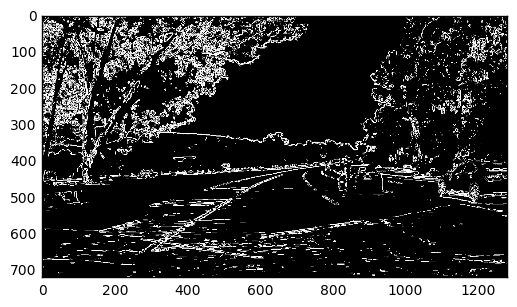

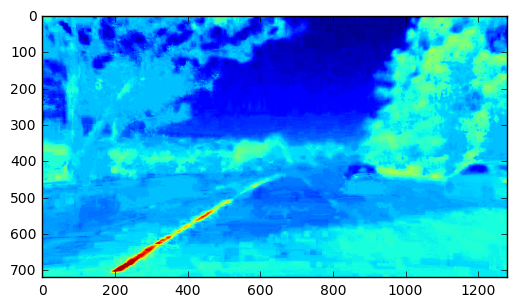

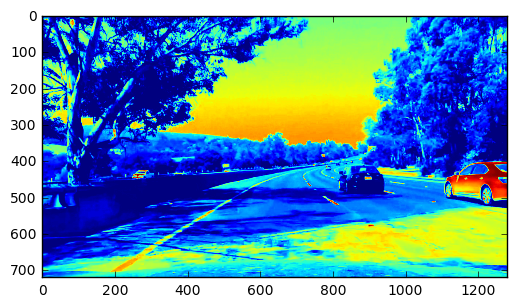

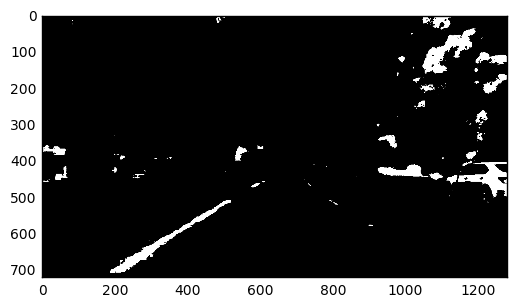

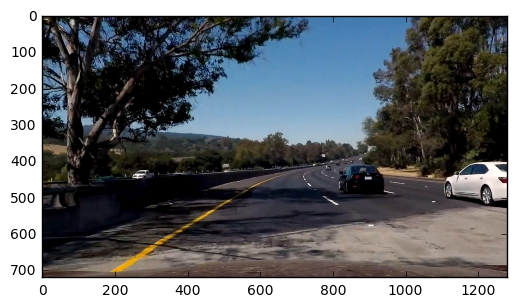

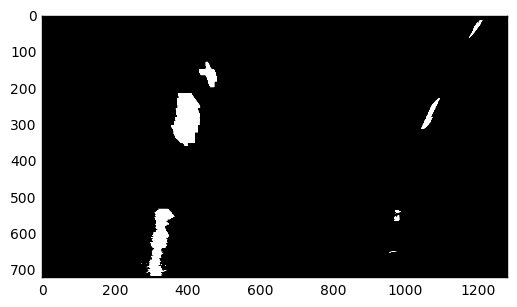

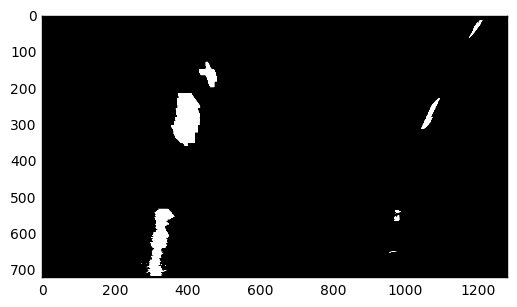

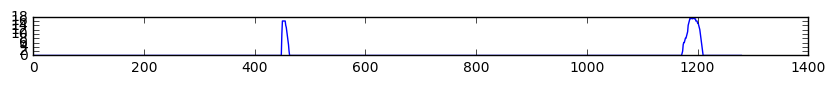

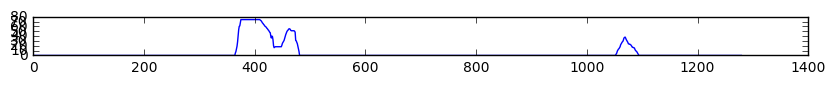

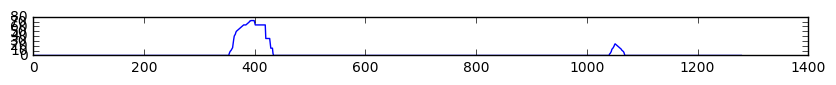

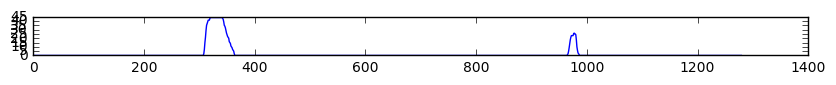

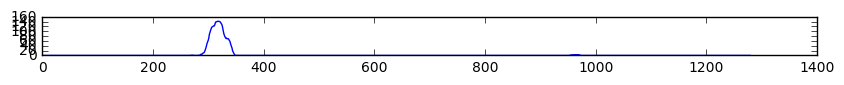

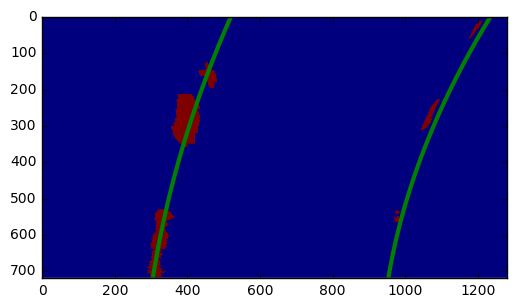

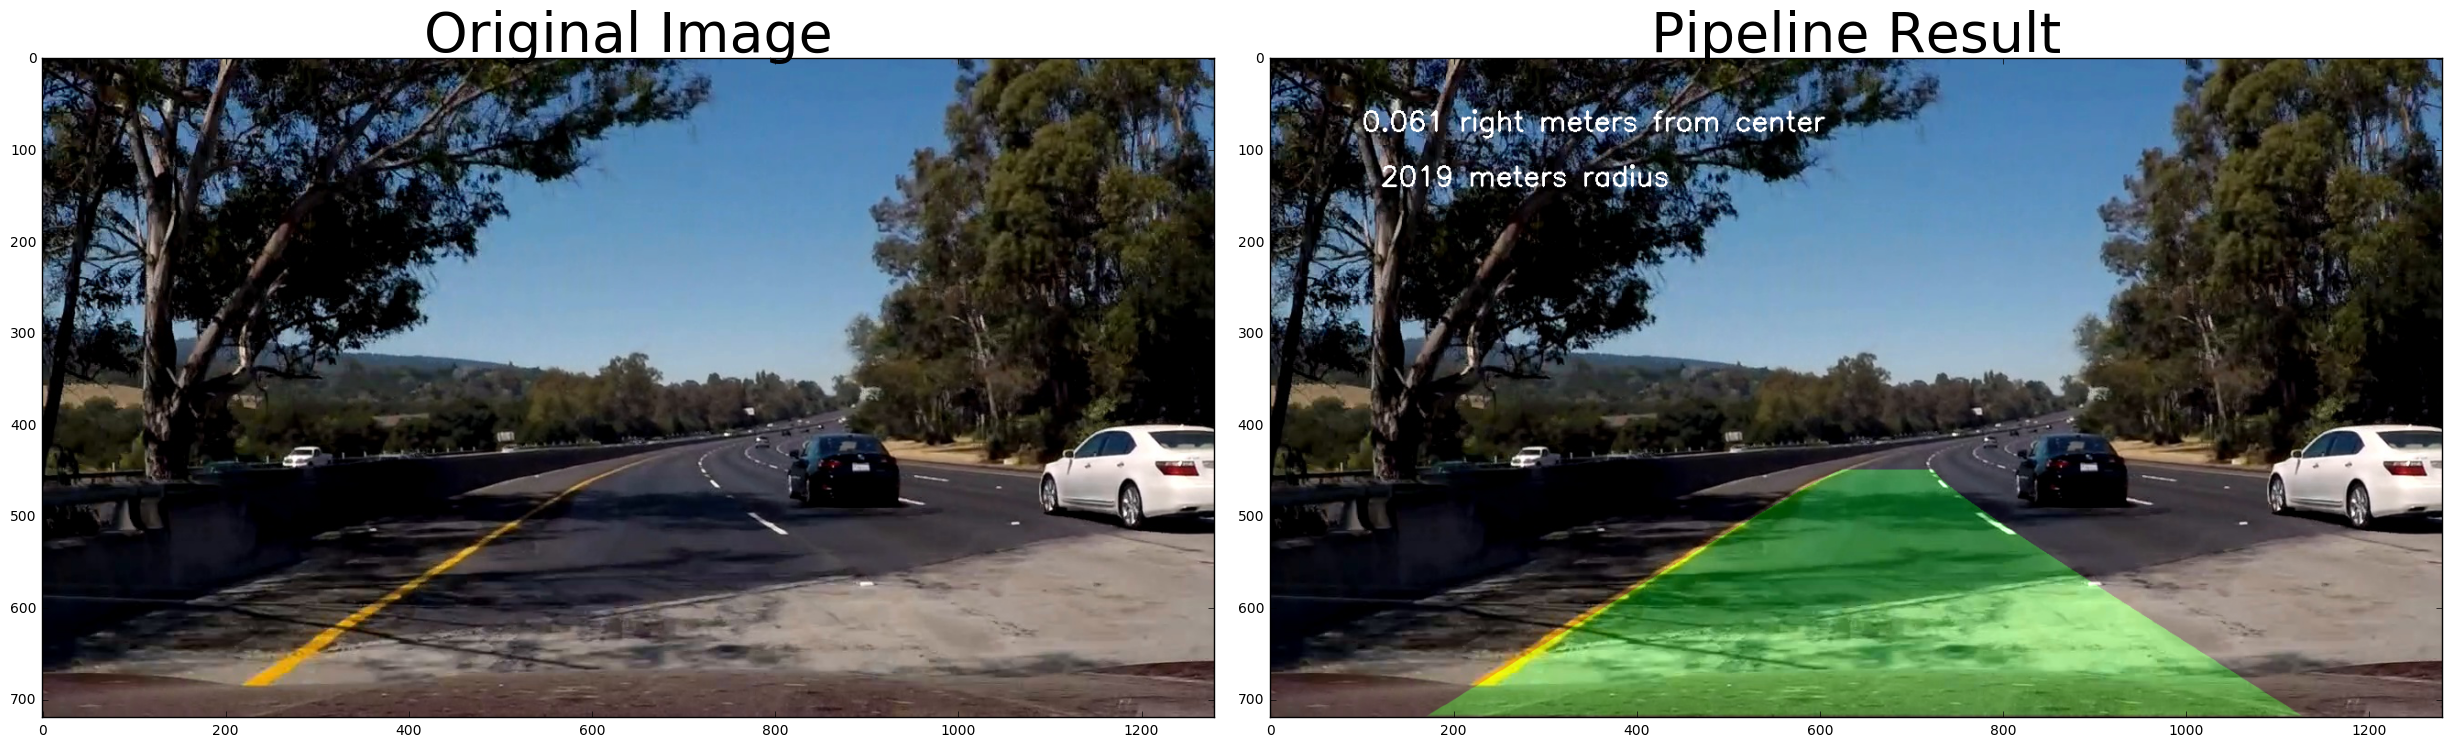

In [407]:
# this is the development time to read and process a single image
count = 1
left_line = Line()
right_line = Line()
#image = mpimg.imread(test_img_loc+'test4.jpg')
image = mpimg.imread('test/1039_img.jpg')

test = process_image(image,True)

#### Process Video

In [394]:
#here we read a video and process every frame in the video through our pipeline process
count = 1
def process_image_i(image):
    return process_image(image,False)
left_line = Line()
right_line = Line()
white_output = 'project_video_annotated.mp4'
clip1 = VideoFileClip("project_video.mp4", audio=False)
white_clip = clip1.fl_image(process_image_i) 
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video project_video_annotated.mp4
[MoviePy] Writing video project_video_annotated.mp4


100%|█████████▉| 1260/1261 [02:12<00:00,  9.59it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_annotated.mp4 

CPU times: user 13min 46s, sys: 3.16 s, total: 13min 49s
Wall time: 2min 12s


In [396]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

#### Lane Extraction